# Graph Neural Network test student first version

Inferior test - keep ratio:
 - same model as inferior teacher = one level (to make a version that is not best performing)
 - take most secure self distillation elements as additional input but keep positive - negative ratio
 - smooth label input: take the predicted value and not 1. or 0.
 - significatly higher level of noise (dropout ratio): 0.5->0.8
 - longer length of training (as dropout may lead to slower learning), 300 epochs
 - shuffled after combining training and sd-data

In [1]:
import sys
sys.path.append('../')
import random

## Importing

In [2]:
from selfdist_toolkit.pyg_tools import gnn_load, GIN_nn, execution, sd_utils, accuracy
import pandas as pd
import torch
import torch_geometric
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import typing

C:\Users\johan\anaconda3\envs\praktikum\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data loading (aid list)

In [3]:
aid_list = pd.read_csv("../results/random_forest/experiments_check/chem-desc_good-aid_1.csv").aid.to_numpy().astype(int)

In [4]:
aid_list

array([    884,     891,     899,     914,    1418,    1431,    1770,
          1771,    1795,  493073,  493102,  493177,  493191,  493240,
        588834,  651741,  651812,  651814,  686978,  687022,  720691,
        743036,  743040,  743065, 1053173, 1259381, 1346982])

## Procedure environment setting

In [5]:
# fraction of self distillation elements to add to training
frac_sd = 1.

In [6]:
# number epochs
epochs = 300
original_epochs = 100

In [7]:
# random state where we want to set it
random_state = 131313

In [8]:
# hard mode - soft mode is actually deprecated
mode = "hard"

In [9]:
# batch size
batch_size=100

## Setting up storage location

In [10]:
# path for csv dataframe
csv_path = "../results/student_exp_inferior_1/csv/"
# path for graphs
graphs_path = "../results/student_exp_inferior_1/graphs/"

In [11]:
# make sure the folder exists
if not os.path.exists(csv_path):
    os.makedirs(csv_path)
if not os.path.exists(graphs_path):
    os.makedirs(graphs_path)

## Determine which self distillation entries to take

In [12]:
def pick_sd_basic(
    num_current: int,
    perc_select: float,
    aid: int,
    pos_to_neg_ratio: float
) -> typing.List[torch_geometric.data.data.Data]:
    
    # =================================================
    # Load self distillation elements for this aid
    # =================================================
    # define path where the self distillation prediction is
    path_sd_data = "../results/teacher_exp_inferior/sd_out/teacher-pred_aid={}_epochs={}.csv".format(aid, original_epochs)

    # read the self distillation data
    df_sd = pd.read_csv(path_sd_data)

    # sort the elements according to their score
    idx_sorted = np.argsort(df_sd.predicted_label_soft.to_numpy())

    # determine number of self distillation elements to fetch
    num_sd = int(perc_select*num_current)
    pos_elem_count = int(num_sd * pos_to_neg_ratio)
    neg_elem_count = num_sd - pos_elem_count
    
    # select most secure positive and negative elements
    select = np.concatenate([idx_sorted[:neg_elem_count], idx_sorted[-pos_elem_count:]])

    # get subset of df to take
    df_sd = df_sd.loc[select]

    # calculate the pyg elements of the chosen elements
    sd_data_list = gnn_load.load_pyg_data_from_smiles_list(df_sd.smiles.tolist(), df_sd.predicted_label_soft.tolist())

    return sd_data_list

## Iteration over assay ids and execution of procedure

In [13]:
forbidden_aid=[686978]

In [14]:
for i, aid in enumerate(aid_list):
    
    # =================================================
    # Progress output
    # =================================================
    # print actual state
    print("current aid: {}, {}/{} - {:2.2%}".format(
        aid,
        i,
        aid_list.shape[0],
        i/aid_list.shape[0]
    ))
    
    # if experiment in forbidden experiments skip it
    if aid in forbidden_aid:
        print("skipped because in forbidden list")
        continue
    
    # =================================================
    # Load data
    # =================================================
    # load data for experiment
    whole_data = gnn_load.load_pyg_data_aid(aid=aid, label_type=mode, do_in_parallel=True, path_data="../data/")
    # seperate because this should only be in training data
    pos_neg_ratio = torch.concatenate([data.y for data in whole_data]).numpy().sum()/len(whole_data)
    sd_data = pick_sd_basic(len(whole_data), frac_sd, aid, pos_neg_ratio)
    
    # get hard labels
    labels_hard = np.array([
        data.y.detach().cpu().numpy()
        for data in whole_data
    ]).flatten().astype(int)
    
    # do data splitting in train and test 80:20
    # data splitting
    for train_idx, test_idx in StratifiedShuffleSplit(n_splits=1, random_state=random_state, test_size=0.2).split(whole_data, labels_hard):
        break
        
    # fuze data and shuffle it to make internal distribution more equal
    fuzed_data = [whole_data[idx] for idx in train_idx] + sd_data
    random.Random(random_state).shuffle(fuzed_data)
    
    
    # generate the dataloader
    dl_train = torch_geometric.loader.DataLoader(fuzed_data, batch_size=(batch_size if aid!=686978 else batch_size*10))
    dl_test = torch_geometric.loader.DataLoader([whole_data[idx] for idx in test_idx], batch_size=(batch_size if aid!=686978 else batch_size*10))
    
    # =================================================
    # Model setup
    # =================================================
    # GNN model
    model = GIN_nn.GIN_basic(1, drop_ratio=0.8, num_layer=1)
    # loss
    loss = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([(len(train_idx) + len(sd_data))/(labels_hard[train_idx].sum() + torch.concatenate([data.y for data in sd_data]).numpy().sum())]))
    # device
    device = torch.device('cuda')
    model = model.to(device)
    loss = loss.to(device)
    # optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # =================================================
    # Epoch iteration
    # =================================================
    # define loss saving space
    loss_storage = []
    
    # define accuracy storage
    accuracy_storage = []
    
    # epoch iterations
    for epoch in tqdm(range(epochs)):
        
        # do training step
        loss_value = execution.training(model, dl_train, device, optimizer, loss, verbose=False)

        # put loss into storage
        loss_storage.append(loss_value)

        # do testing step
        y_pred_hard = execution.predict(model, dl_test, device, reduce_to_hard_label=True, verbose=False)

        # calculate accuracy DataFrame
        accuracy_storage.append(
            # get accuracy class and from it the DataFrame
            accuracy.calculate_accuracies_1d(
                y_pred=y_pred_hard, 
                y_true=accuracy.helper_pyg_to_numpy_label(
                    data_loader=dl_test
                )
            ).to_df(index=epoch)
        )
    
    # transform accuracy storage to pandas df
    accuracy_storage = pd.concat(accuracy_storage)

    # add new column for loss
    accuracy_storage['loss'] = loss_storage
    
    # =================================================
    # Save data to file
    # =================================================
    # set file path
    file_path = csv_path + "student-acc_aid={}_epochs={}.csv".format(aid, epochs)
    
    # write to file
    accuracy_storage.to_csv(file_path, index=True, index_label="epoch")

current aid: 884, 0/27 - 0.00%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [11:27<00:00,  2.29s/it]


current aid: 891, 1/27 - 3.70%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [08:41<00:00,  1.74s/it]


current aid: 899, 2/27 - 7.41%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [09:06<00:00,  1.82s/it]


current aid: 914, 3/27 - 11.11%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [08:27<00:00,  1.69s/it]


current aid: 1418, 4/27 - 14.81%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:21<00:00,  3.70it/s]


current aid: 1431, 5/27 - 18.52%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:29<00:00,  3.37it/s]


current aid: 1770, 6/27 - 22.22%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:29<00:00,  3.36it/s]


current aid: 1771, 7/27 - 25.93%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:15<00:00,  3.97it/s]


current aid: 1795, 8/27 - 29.63%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:26<00:00,  3.46it/s]


current aid: 493073, 9/27 - 33.33%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:26<00:00,  3.49it/s]


current aid: 493102, 10/27 - 37.04%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:25<00:00,  3.52it/s]


current aid: 493177, 11/27 - 40.74%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:22<00:00,  3.62it/s]


current aid: 493191, 12/27 - 44.44%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:36<00:00,  3.10it/s]


current aid: 493240, 13/27 - 48.15%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:24<00:00,  3.53it/s]


current aid: 588834, 14/27 - 51.85%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [03:22<00:00,  1.48it/s]


current aid: 651741, 15/27 - 55.56%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:26<00:00,  3.47it/s]


current aid: 651812, 16/27 - 59.26%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:58<00:00,  2.53it/s]


current aid: 651814, 17/27 - 62.96%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:21<00:00,  3.68it/s]


current aid: 686978, 18/27 - 66.67%
skipped because in forbidden list
current aid: 687022, 19/27 - 70.37%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:14<00:00,  4.04it/s]


current aid: 720691, 20/27 - 74.07%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [06:29<00:00,  1.30s/it]


current aid: 743036, 21/27 - 77.78%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [05:51<00:00,  1.17s/it]


current aid: 743040, 22/27 - 81.48%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [06:50<00:00,  1.37s/it]


current aid: 743065, 23/27 - 85.19%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [06:20<00:00,  1.27s/it]


current aid: 1053173, 24/27 - 88.89%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:52<00:00,  2.67it/s]


current aid: 1259381, 25/27 - 92.59%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [06:45<00:00,  1.35s/it]


current aid: 1346982, 26/27 - 96.30%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [06:14<00:00,  1.25s/it]


## Generate the graphs

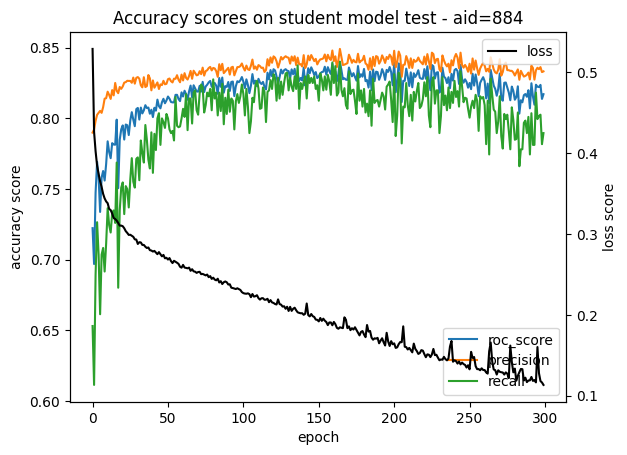

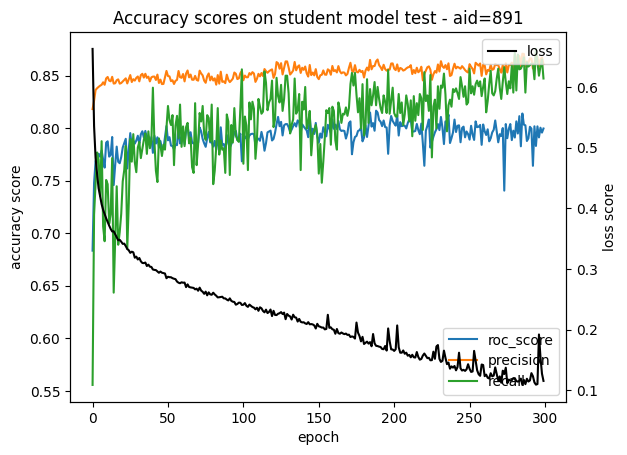

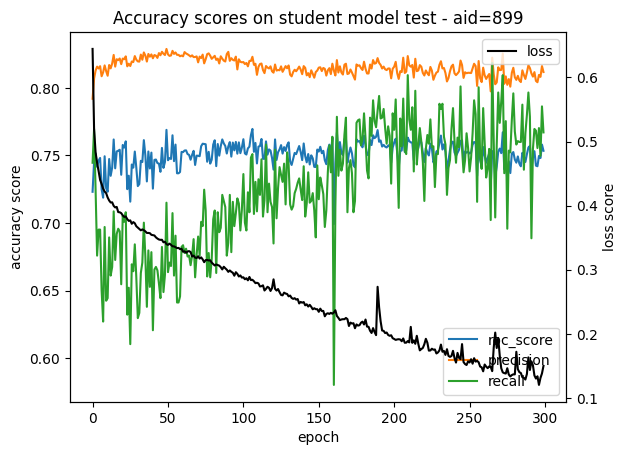

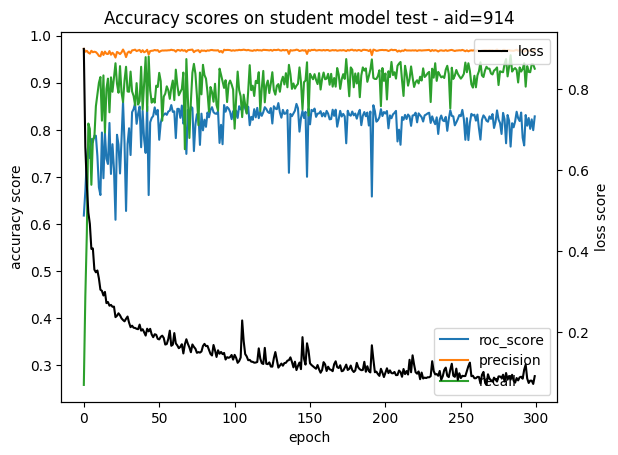

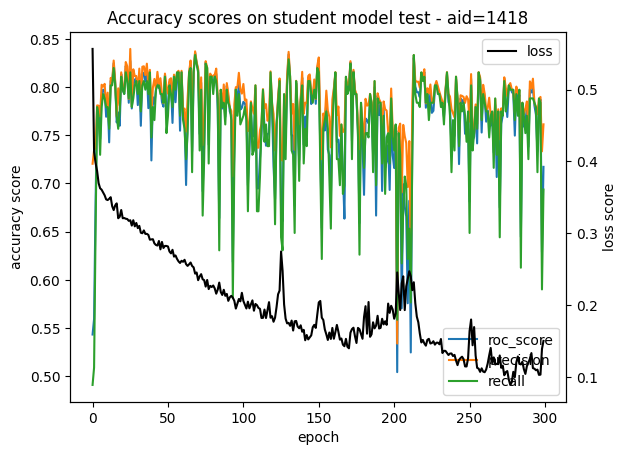

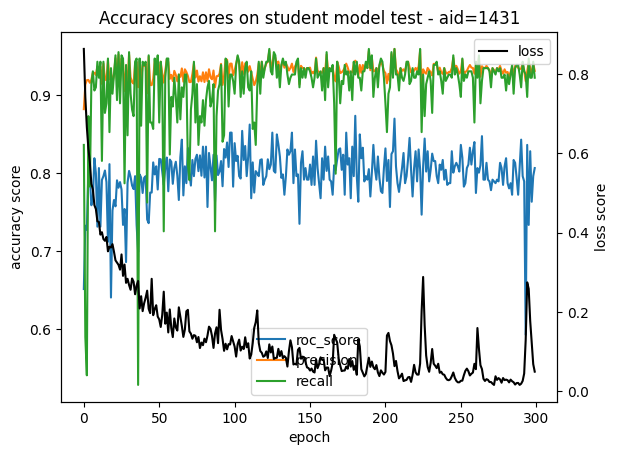

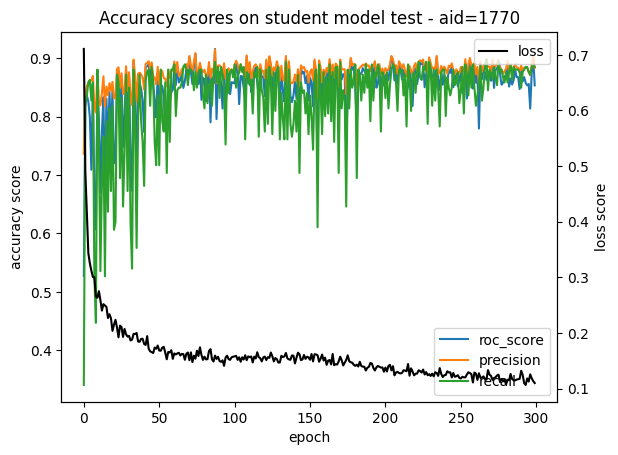

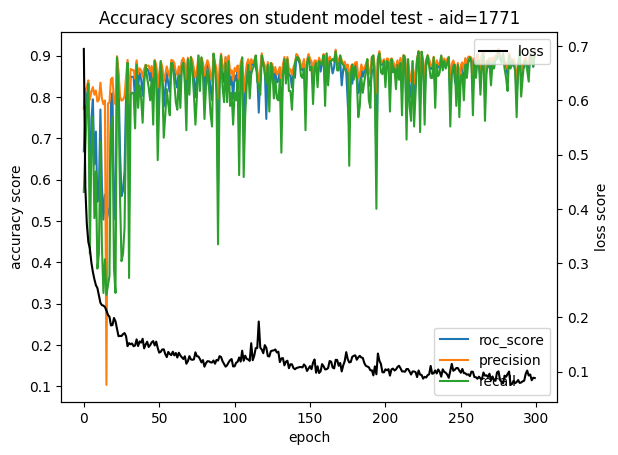

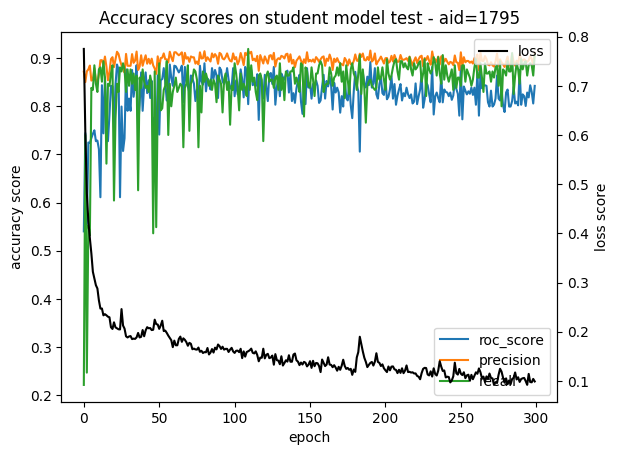

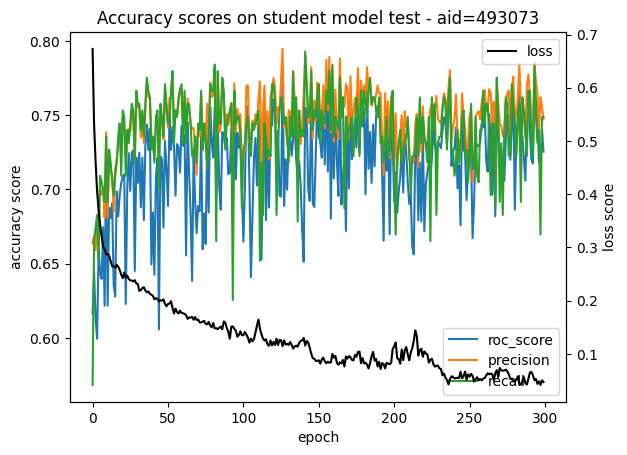

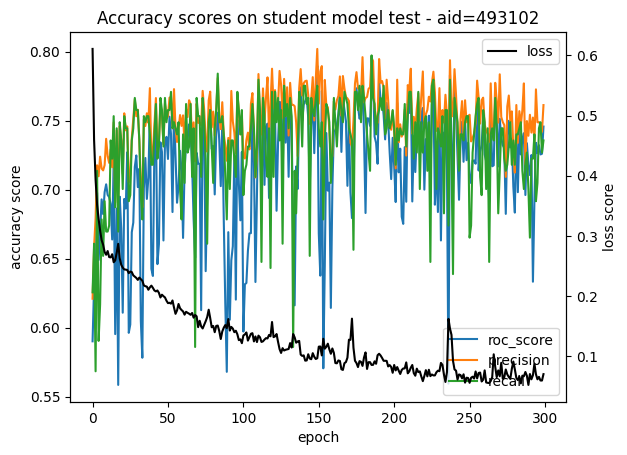

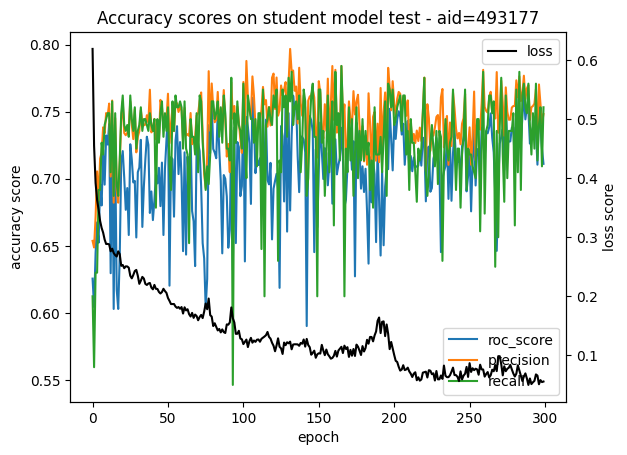

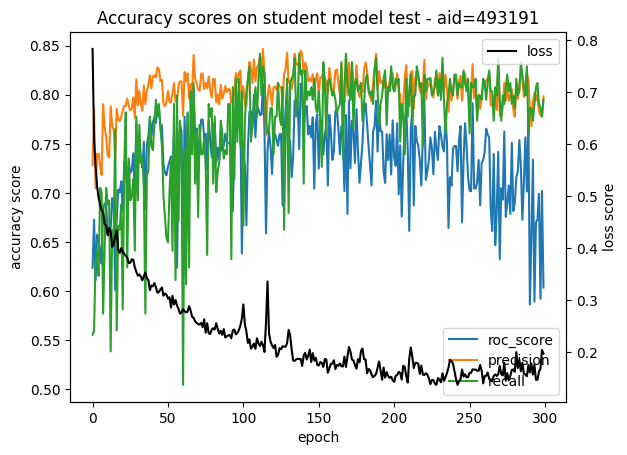

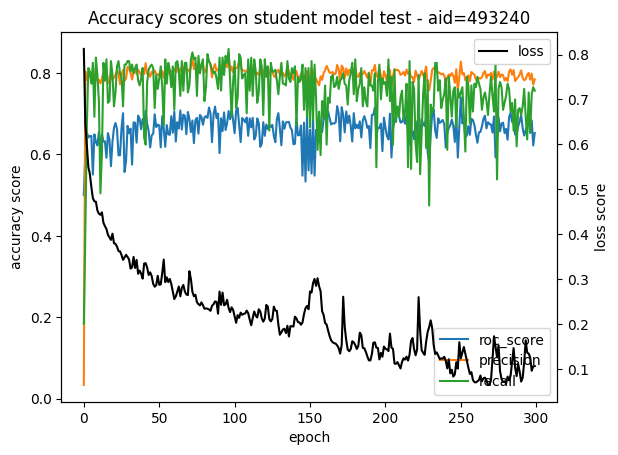

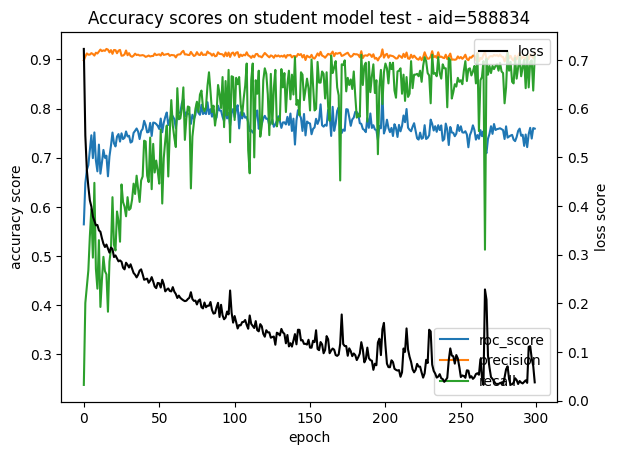

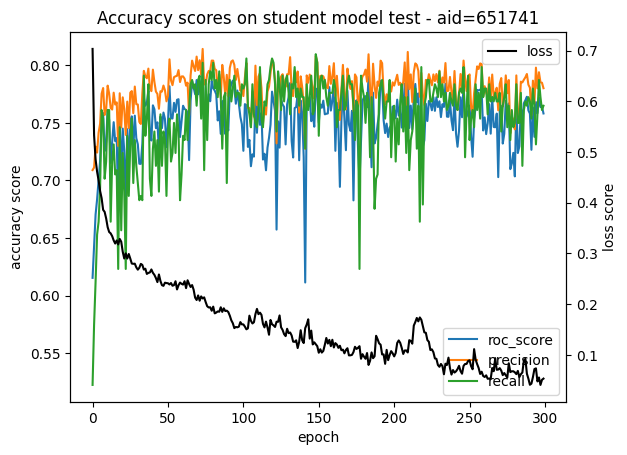

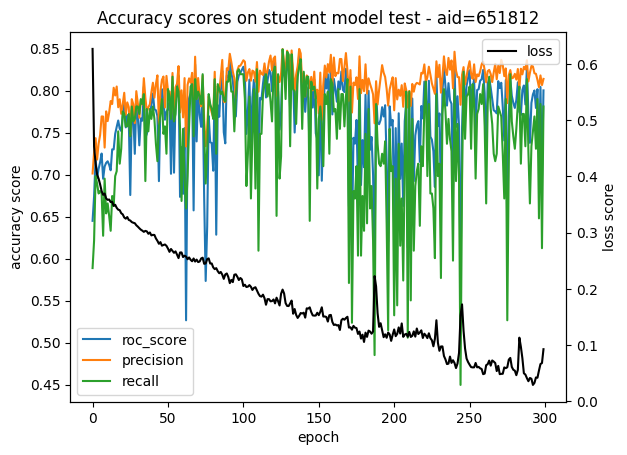

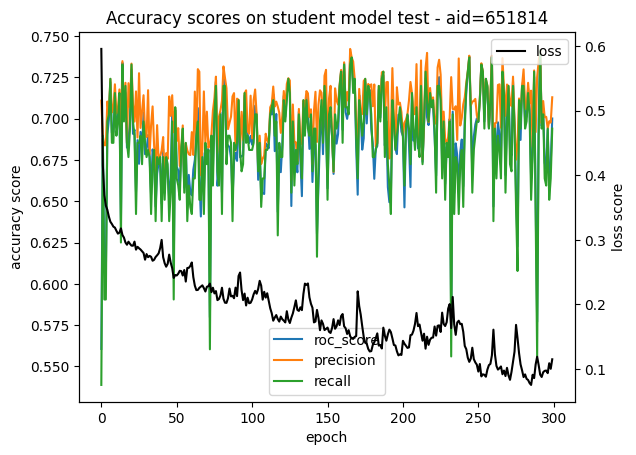

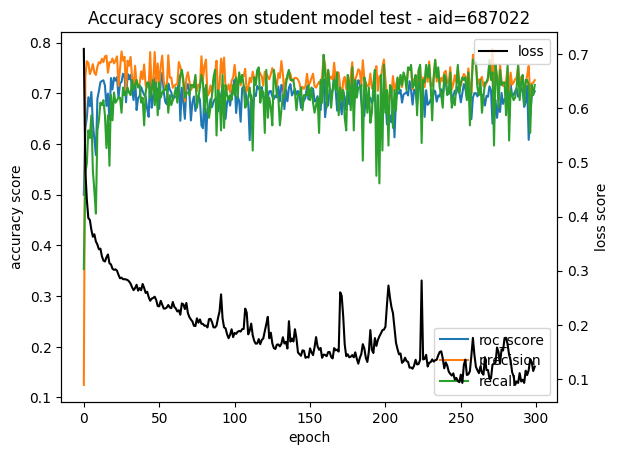

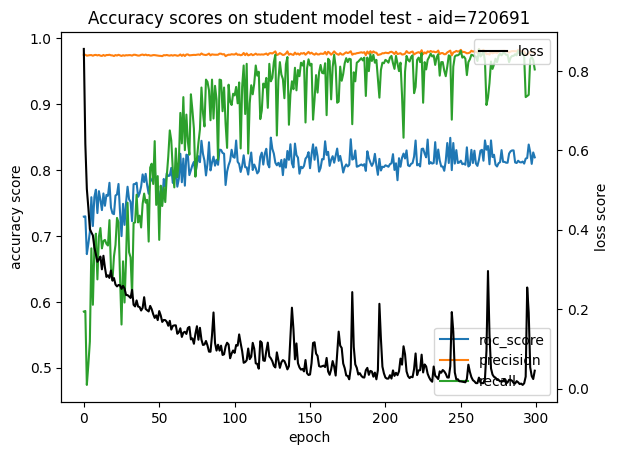

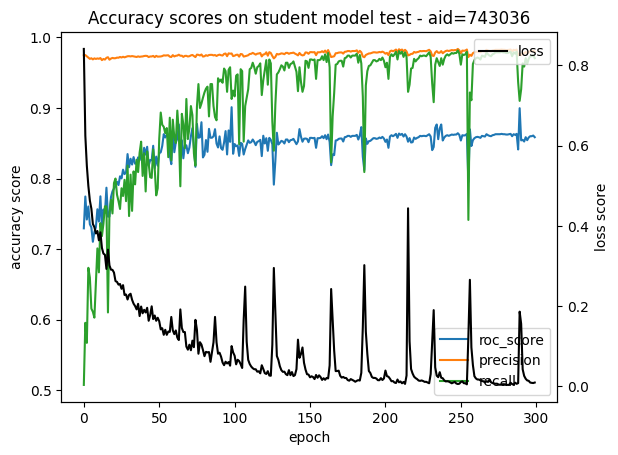

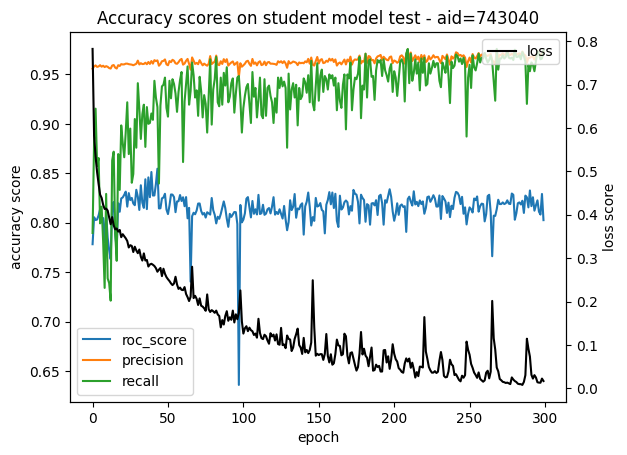

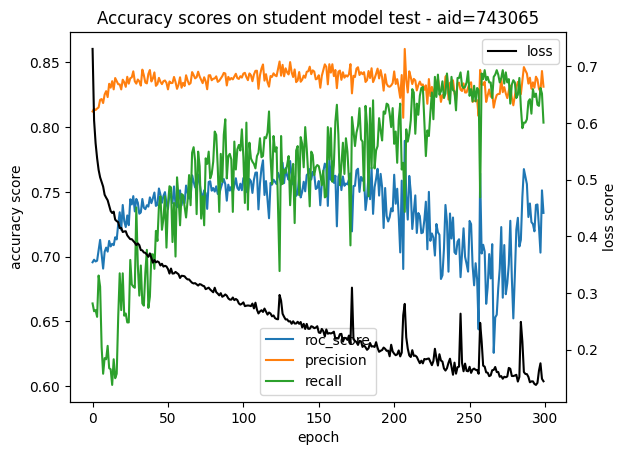

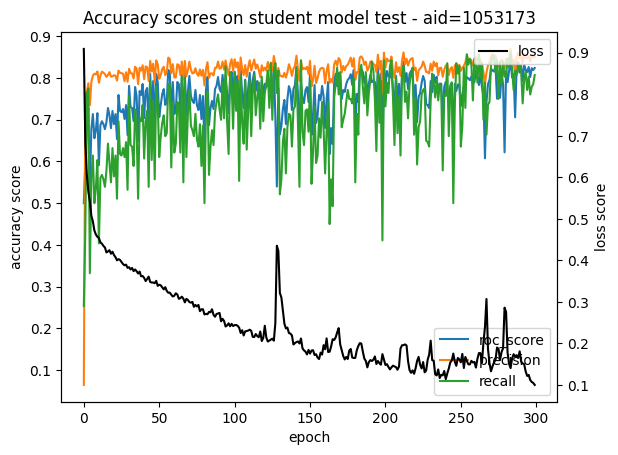

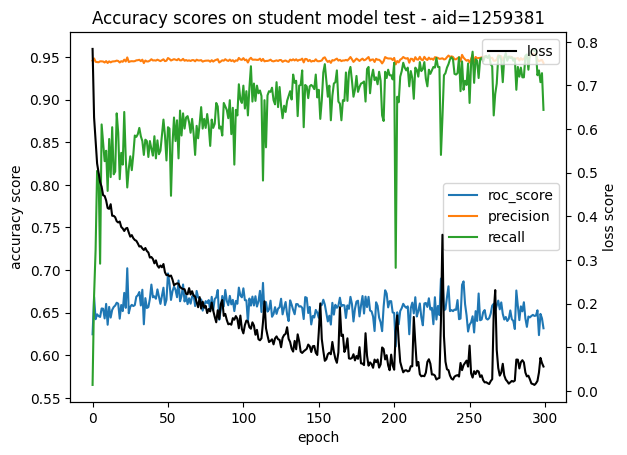

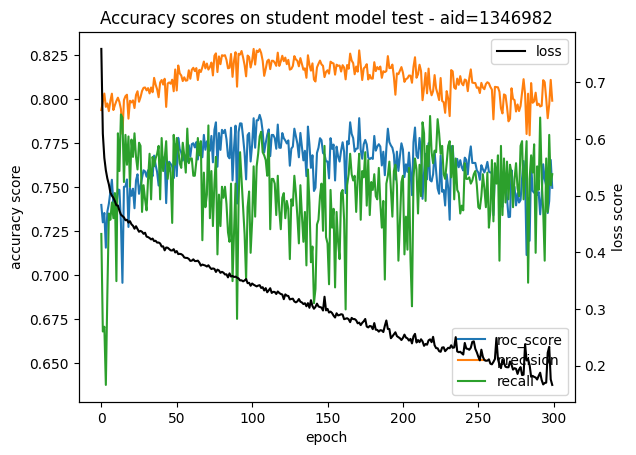

In [15]:
for aid in aid_list:
    
    # if experiment in forbidden experiments skip it
    if aid in forbidden_aid:
        continue
    
    # determine storage location of csv
    file_path = csv_path + "student-acc_aid={}_epochs={}.csv".format(aid, epochs)
    
    # determine storage location of image
    file_path_plot = graphs_path + "StudentAccs_aid-{}_epochs-{}.png".format(aid, epochs)
    
    # load the csv
    loaded_csv = pd.read_csv(file_path, index_col="epoch")
    
    # plotting
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(loaded_csv.roc_score, label="roc_score")
    ax1.plot(loaded_csv.precision, label="precision")
    ax1.plot(loaded_csv.recall, label="recall")
    ax2.plot(loaded_csv.loss, color="black", label="loss")
    
    ax1.set_xlabel("epoch")
    ax1.set_ylabel("accuracy score")
    ax2.set_ylabel("loss score")
    ax1.legend()
    ax2.legend()
    plt.title("Accuracy scores on student model test - aid={}".format(aid))
    plt.savefig(file_path_plot, bbox_inches='tight')
    plt.show()